<a href="https://colab.research.google.com/github/safa-abidi/NLP-fakeReviewsDetection-AraBert/blob/main/GANBERT_pytorch_all_metrics_with_preprocessing_with_test_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT

Let's GO!

Required Imports.

In [1]:
!pip install transformers==4.3.2
!pip install scikit-learn
!pip install transformers
!pip install torch
!pip install arabic_reshaper
!pip install python-bidi
!pip install pyarabic
import torch
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer
import pandas as pd
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd
import os

from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from typing import Any, Dict, List, Callable, Optional, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import torch

import time

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 28.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=9ef113c27a795a568771cc42b58ff9143d4d8b8e81ca1ae11884c84171a15cb3
  Stored in directory: /r

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import xml.etree.ElementTree as ET

In [5]:
DATASETS_PATH = '/content/drive/MyDrive/'

%cd /content/drive/MyDrive/datasets

# Labeled Dataset
labeled_dataset_path = 'dataset_arabic_translated/Merged_Labelled_Arabic_fake_news_Dataset.xlsx'
labeled_dataset = pd.read_excel(labeled_dataset_path)
print("Labeled Dataset : ",labeled_dataset.shape)

# Unlabeled Dataset 1
unlabeled_dataset_path1 = 'SemEval2016_arabic/AR_Hotels_Train_SB1.xml'
tree = ET.parse(unlabeled_dataset_path1)
root = tree.getroot()
reviews = []
for review in root.iter('Review'):
    for sentence in review.iter('sentence'):
        text = sentence.find('text').text.strip()
        label = -1
        reviews.append((text, label))

# Create a pandas DataFrame from the list of tuples
unlabeled_dataset_1 = pd.DataFrame(reviews, columns=['Review', 'Class'])
print("First Unlabeled Dataset : ",unlabeled_dataset_1.shape)

#Unlabeled Dataset 2
unlabeled_dataset_path2 = "Merged_Unlabelled_Arabic_scraped_Hotel reviews.xlsx"
unlabeled_dataset_2 = pd.read_excel(unlabeled_dataset_path2, sheet_name="Sheet1")
unlabeled_dataset_2["Class"] = -1
unlabeled_dataset_2 = unlabeled_dataset_2[["Review", "Class"]]

print("Second Unlabeled Dataset : " , unlabeled_dataset_2.shape)

#Merge unlabeled datasets
unlabeled_dataset = pd.concat([unlabeled_dataset_1,unlabeled_dataset_2])
print("Merged Unlabeled Dataset : " , unlabeled_dataset.shape)

/content/drive/MyDrive/datasets
Labeled Dataset :  (1600, 6)
First Unlabeled Dataset :  (4802, 2)
Second Unlabeled Dataset :  (799, 2)
Merged Unlabeled Dataset :  (5601, 2)


In [6]:
from sklearn.model_selection import train_test_split
# data split labeled_training and test
df_train_labeled, df_test = train_test_split(labeled_dataset, train_size=0.7, random_state=0)
print('Size of train dataframe: ', df_train_labeled.shape[0])
print('Size of test dataframe: ', df_test.shape[0])

## Encode the dataset labels
df_test['label'] =  df_test.apply(lambda x: 0 if x['Class'] == 'خادع' else 1 if x['Class'] == 'صادقة' else -1, axis=1)
df_train_labeled['label'] = df_train_labeled.apply(lambda x: 0 if x['Class'] == 'خادع' else 1 if x['Class'] == 'صادقة' else -1, axis=1)

# Load the examples
# labeled_examples = df_train_labeled
# unlabeled_examples = unlabeled_dataset
# test_examples = df_test

Size of train dataframe:  1120
Size of test dataframe:  480


In [7]:
#-----------------------------#
X_test = df_test['Review']
y_test = df_test['label'].values

### Input Parameters


In [8]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 20
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 20

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "aubmindlab/bert-base-arabertv2"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
! git clone https://github.com/crux82/ganbert


label_list = [0,1,-1]

fatal: destination path 'ganbert' already exists and is not an empty directory.


In [9]:
from sklearn.svm import SVC
from transformers import AutoModel

Load the Tranformer Model

In [10]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/pytorch_model.bin
Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a 

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/config.json
Model config BertConfig {
  "_name_

Function required to load the dataset

Functions required to convert examples into Dataloader

#Preproc

In [11]:
!pip install arabic_stopwords
!pip install farasa
!pip install farasapy

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
import re
import string
from nltk.stem import ISRIStemmer
from farasa.stemmer import FarasaStemmer
from nltk.stem import PorterStemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
COMMA = u'\u060C'
SEMICOLON = u'\u061B'
QUESTION = u'\u061F'
HAMZA = u'\u0621'
ALEF_MADDA = u'\u0622'
ALEF_HAMZA_ABOVE = u'\u0623'
WAW_HAMZA = u'\u0624'
ALEF_HAMZA_BELOW = u'\u0625'
YEH_HAMZA = u'\u0626'
ALEF = u'\u0627'
BEH = u'\u0628'
TEH_MARBUTA = u'\u0629'
TEH = u'\u062a'
THEH = u'\u062b'
JEEM = u'\u062c'
HAH = u'\u062d'
KHAH = u'\u062e'
DAL = u'\u062f'
THAL = u'\u0630'
REH = u'\u0631'
ZAIN = u'\u0632'
SEEN = u'\u0633'
SHEEN = u'\u0634'
SAD = u'\u0635'
DAD = u'\u0636'
TAH = u'\u0637'
ZAH = u'\u0638'
AIN = u'\u0639'
GHAIN = u'\u063a'
TATWEEL = u'\u0640'
FEH = u'\u0641'
QAF = u'\u0642'
KAF = u'\u0643'
LAM = u'\u0644'
MEEM = u'\u0645'
NOON = u'\u0646'
HEH = u'\u0647'
WAW = u'\u0648'
ALEF_MAKSURA = u'\u0649'
YEH = u'\u064a'
MADDA_ABOVE = u'\u0653'
HAMZA_ABOVE = u'\u0654'
HAMZA_BELOW = u'\u0655'
ZERO = u'\u0660'
ONE = u'\u0661'
TWO = u'\u0662'
THREE = u'\u0663'
FOUR = u'\u0664'
FIVE = u'\u0665'
SIX = u'\u0666'
SEVEN = u'\u0667'
EIGHT = u'\u0668'
NINE = u'\u0669'
PERCENT = u'\u066a'
DECIMAL = u'\u066b'
THOUSANDS = u'\u066c'
STAR = u'\u066d'
MINI_ALEF = u'\u0670'
ALEF_WASLA = u'\u0671'
FULL_STOP = u'\u06d4'
BYTE_ORDER_MARK = u'\ufeff'

# Diacritics
FATHATAN = u'\u064b'
DAMMATAN = u'\u064c'
KASRATAN = u'\u064d'
FATHA = u'\u064e'
DAMMA = u'\u064f'
KASRA = u'\u0650'
SHADDA = u'\u0651'
SUKUN = u'\u0652'

#Ligatures
LAM_ALEF = u'\ufefb'
LAM_ALEF_HAMZA_ABOVE = u'\ufef7'
LAM_ALEF_HAMZA_BELOW = u'\ufef9'
LAM_ALEF_MADDA_ABOVE = u'\ufef5'
SIMPLE_LAM_ALEF = u'\u0644\u0627'
SIMPLE_LAM_ALEF_HAMZA_ABOVE = u'\u0644\u0623'
SIMPLE_LAM_ALEF_HAMZA_BELOW = u'\u0644\u0625'
SIMPLE_LAM_ALEF_MADDA_ABOVE = u'\u0644\u0622'

HARAKAT_PAT = re.compile(u"["+u"".join([FATHATAN, DAMMATAN, KASRATAN,
                                        FATHA, DAMMA, KASRA, SUKUN,
                                        SHADDA])+u"]")
HAMZAT_PAT = re.compile(u"["+u"".join([WAW_HAMZA, YEH_HAMZA])+u"]")
ALEFAT_PAT = re.compile(u"["+u"".join([ALEF_MADDA, ALEF_HAMZA_ABOVE,
                                       ALEF_HAMZA_BELOW, HAMZA_ABOVE,
                                       HAMZA_BELOW])+u"]")
LAMALEFAT_PAT = re.compile(u"["+u"".join([LAM_ALEF,
                                          LAM_ALEF_HAMZA_ABOVE,
                                          LAM_ALEF_HAMZA_BELOW,
LAM_ALEF_MADDA_ABOVE])+u"]")

WESTERN_ARABIC_NUMERALS = ['0','1','2','3','4','5','6','7','8','9']

#EASTERN_ARABIC_NUMERALS = [u'\u06F0', u'\u06F1', u'\u06F2', u'\u06F3', u'\u0664', u'\u06F5', u'\u0666', u'\u06F7', u'\u06F8', u'\u06F9']
EASTERN_ARABIC_NUMERALS = [u'۰', u'۱', u'۲', u'۳', u'٤', u'۵', u'٦', u'۷', u'۸', u'۹']


eastern_to_western_numerals = {}
for i in range(len(EASTERN_ARABIC_NUMERALS)):
    eastern_to_western_numerals[EASTERN_ARABIC_NUMERALS[i]] = WESTERN_ARABIC_NUMERALS[i]

# Punctuation marks
COMMA = u'\u060C'
SEMICOLON = u'\u061B'
QUESTION = u'\u061F'

# Other symbols
PERCENT = u'\u066a'
DECIMAL = u'\u066b'
THOUSANDS = u'\u066c'
STAR = u'\u066d'
FULL_STOP = u'\u06d4'
MULITIPLICATION_SIGN = u'\u00D7'
DIVISION_SIGN = u'\u00F7'

arabic_punctuations = COMMA + SEMICOLON + QUESTION + PERCENT + DECIMAL + THOUSANDS + STAR + FULL_STOP + MULITIPLICATION_SIGN + DIVISION_SIGN
all_punctuations = string.punctuation + arabic_punctuations + '()[]{}'

all_punctuations = ''.join(list(set(all_punctuations)))



stemmer = FarasaStemmer(interactive=True)
i_stemmer = PorterStemmer()


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:19<00:00, 12.5MiB/s]


[2023-05-30 14:23:34,186 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [13]:
def strip_diacritics(text):
    text = HARAKAT_PAT.sub('', text)
    text = re.sub(u"[\u064E]", "", text,  flags=re.UNICODE) # fat'ha
    text = re.sub(u"[\u0671]", "", text,  flags=re.UNICODE) # wasla
    return text 


def strip_tatweel(text):
    return re.sub(u'[%s]' % TATWEEL, '', text)


def remove_non_arabic(text):
    return ' '.join(re.sub(u"[^\u0621-\u063A\u0640-\u0652 ]", " ", text,  flags=re.UNICODE).split())


def keep_arabic_english_n_symbols(text):
    return ' '.join(re.sub(u"[^\u0621-\u063A\u0640-\u0652a-zA-Z#@_:/ ]", " ", text,  flags=re.UNICODE).split())


def normalize_hamza(text):
    text = ALEFAT_PAT.sub(ALEF, text)
    return HAMZAT_PAT.sub(HAMZA, text)


def normalize_spellerrors(text):
    text = re.sub(u'[%s]' % TEH_MARBUTA, HEH, text)
    return re.sub(u'[%s]' % ALEF_MAKSURA, YEH, text)


def normalize_lamalef(text):
    return LAMALEFAT_PAT.sub(u'%s%s'%(LAM, ALEF), text)


def normalize_arabic_text(text):
    text = remove_non_arabic(text)
    text = strip_diacritics(text)
    text = strip_tatweel(text)
    
    text = stemmer.stem(text)
    
    text = normalize_lamalef(text)
    text = normalize_hamza(text)
    text = normalize_spellerrors(text)
    return text


def remove_underscore(text):
    return ' '.join(text.split('_'))

def replace_emails(text):
    emails = re.findall(r'[\w\.-]+@[\w\.-]+', text)
    for email in emails:
        text = text.replace(email,' ايميل هنا ')
        #text = text.replace(email,' hasEmailAddress ')
    return text

def replace_urls(text):
    return re.sub(r"http\S+|www.\S+", " رابط هنا ", text)
    #return re.sub(r"http\S+|www.\S+", " hasURL ", text)

def convert_eastern_to_western_numerals(text):
    for num in EASTERN_ARABIC_NUMERALS:
        text = text.replace(num, eastern_to_western_numerals[num])
    return text

def remove_all_punctuations(text):
    for punctuation in all_punctuations:
        text = text.replace(punctuation, ' ')
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def replace_phone_numbers(text):
    return re.sub(r'\d{10}', ' رقم هاتف هنا ', text)
    # return re.sub(r'\d{10}', ' hasPhoneNumber ', text)

def remove_extra_spaces(text):
    return ' '.join(text.split())

def remove_stopwords(text_in):
    stopwords = stopwords_list()
    text_out = ' '.join(filter(lambda word: word not in stopwords, text_in.split(' ')))
    return text_out


In [14]:
def replace_tatweel(text):
    TATWEEL = u'\u0640'
    text_list = list(text.split())
    new_text_list = text_list.copy()
    for (index,word) in enumerate(text_list):
          if re.search(TATWEEL, word):
              word_index = new_text_list.index(word, index)
              new_text_list.insert(word_index + 1, 'جدا')
    text = ' '.join(new_text_list)
    return re.sub(u'[%s]' % TATWEEL, '', text)

In [15]:
def replace_emoticon1(text):
  emojis_dict = pd.read_excel("emoticons.xlsx", names=["symbol", "symbol2", "text"])#.to_dict('records')
  new_text = text
  for emoj in emojis_dict.values:
    new_text = new_text.replace(emoj[0], emoj[2]).replace("وجه","")
  return new_text

In [16]:
def replace_redundant_lettersv2(text):
    text_list = list(text.split())
    new_text_list = text_list.copy()
    new_list = []

    for (index,word) in enumerate(text_list):
      new_word = re.sub("(.)\\1{2,}", "\\1", word)  
      new_list.append(new_word)

    text = ' '.join(new_list)
    return text   

In [17]:
from nltk.tokenize import word_tokenize # ,sent_tokenize
from nltk.corpus import stopwords

def remove_stopwords2(text):

    rem_ele = [   'لسنا','لستما','سوي','لكنما','غير','لكن','أقل','أكثر','إلا','بؤسا', 'بئس','لا',  'ليس','لم','ليست', 'ليسوا','لن']
    arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
    new_stopwords= arb_stopwords - set(rem_ele)

    processed_word_list = []
    word_list=word_tokenize(text) 

    for word in word_list:
      if word not in list(new_stopwords):
          processed_word_list.append(word)

    return " ".join(processed_word_list)


In [18]:
def farasa_stemmer(text):
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  # Join the stemmed words back into a sentence  
  text = ' '.join(stemmed_words)
  return text

In [19]:
def iris_stemmer(text):
    stemmed_sentence = " ".join(i_stemmer.stem(word) for word in text.split())
    return stemmed_sentence


In [20]:
def normalize_text(text):
  new_text = text
  
  new_text = strip_diacritics(new_text)
  new_text = replace_tatweel(new_text)
  new_text = replace_emails(new_text)
  new_text = replace_phone_numbers(new_text)
  new_text = replace_urls(new_text)
  new_text = farasa_stemmer(new_text)
  new_text = replace_emoticon1(new_text)
  return new_text

In [21]:
def normalize_text_with_print(text):
  print("Initial text : \n", text)

  new_text = replace_emoticon1(text)
  print("Text after replacing emoticons : \n", text)

  new_text = strip_diacritics(new_text)
  print("Text after strip diacritics : \n", new_text)

  new_text = strip_tatweel(new_text)
  print("Text after strip tatweel : \n", new_text)

  new_text = replace_redundant_lettersv2(new_text)
  print("Text after replace redundant letters : \n", new_text)

  new_text = normalize_spellerrors(new_text)
  print("Text after normalizing spellerrors : \n", new_text)

  new_text = replace_emails(new_text)
  print("Text after replacing emails : \n", new_text)

  new_text = remove_underscore(new_text)
  print("Text after removing undersocres : \n", new_text)

  new_text = replace_phone_numbers(new_text)
  print("Text after removing phone numbers : \n", new_text)

  new_text = remove_all_punctuations(new_text)
  print("Text after removing punctuations : \n", new_text)

  new_text = replace_urls(new_text)
  print("Text after replacing urls : \n", new_text)

  new_text = convert_eastern_to_western_numerals(new_text)
  print("Text after convert to western numerals : \n", new_text)

  new_text = keep_arabic_english_n_symbols(new_text)
  print("Text after keeping arabic english symbols : \n", new_text)

  new_text = remove_non_arabic(new_text)
  print("Text after removing non arabic : \n", new_text)

  new_text = remove_extra_spaces(new_text)
  print("Text after removing extrea spaces : \n", new_text)

  print("Final text : \n", new_text)

  return new_text

In [22]:
def process_text_with_print(x):
  #text = x['reviews']
  processed_text = normalize_text_with_print(x)
  #x['reviews'] = processed_text
  return x

In [23]:
def process_text(x):
  #text = x['reviews']
  processed_text = normalize_text(x)
  #x2 = processed_text
  #x['reviews'] = processed_text
  return processed_text

In [24]:
def df_process(dataset):
  dataset = dataset.apply(process_text)
  return dataset

In [25]:
unlabeled_dataset_preprocessed = df_process(unlabeled_dataset["Review"])
X_train_labeled_preprocessed = df_process(df_train_labeled['Review'])
X_test_preprocessed = df_process(df_test['Review'])

In [26]:
print(unlabeled_dataset_preprocessed[0])
print(unlabeled_dataset["Review"][0])

0    نصح نوم ليس تناول طعام موقع مثالي إقامة قبل رح...
0    كل شكر الي كل عامل في هدا فندق فندق ممتاز في خ...
Name: Review, dtype: object
0    أنصح بالنوم وليس تناول الطعام  موقع مثالي للإق...
0    كل الشكر الي كل العاملين في هدا الفندق  فندق م...
Name: Review, dtype: object


In [27]:
#Load the examples
labeled_examples = X_train_labeled_preprocessed
unlabeled_examples = unlabeled_dataset_preprocessed
test_examples = X_test_preprocessed

In [28]:
# pca_437 = PCA(n_components = 437)
# X_train_pca = pca_437.fit_transform(X_train_tokenized)
# X_test_pca = pca_437.transform(X_test_tokenized)
# X_unlabeled_pca = pca_437.transform(X_unlabeled_tokenized)
# print("Size train after PCA 437: ", X_train_pca.shape)
# print("Size test after PCA 437: ", X_test_pca.shape)
# print("Size unlabeled after PCA 437: ", X_unlabeled_pca.shape)
# clf_99, iterations_99, test_f1s_99, pseudo_labels_99, X_test_pca_99 = train(X_train_pca,y_train_labeled,X_test_pca,y_test,X_unlabeled_pca, 0.99)

In [29]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Convert the input examples into DataLoader

In [30]:
labeled_examples = list(zip(df_train_labeled['Review'].tolist(), df_train_labeled['label'].tolist()))
test_examples = list(zip(df_test['Review'].tolist(), df_test['label'].tolist()))

unlabeled_examples = list(zip(unlabeled_dataset['Review'].tolist(), [-1 for _ in range(len(unlabeled_dataset['Review']))]))
print(unlabeled_examples)

[('أنصح بالنوم وليس تناول الطعام  موقع مثالي للإقامة قبل رحلة طيران مبكرة.', -1), ('كانت الغرفة ممتازة وكذلك الموظفون وبوفيه الإفطار. ومع ذلك فقد كانت وجبة العشاء في المطعم باهظة الثمن وغير مرضية.', -1), ('فندق يتميز بمرافق نوعيّة وخلّاقة وساخنة. قم بشراء وجبة داخل الغرفة من M _ S عند الوصول في المطار بدلا من ذلك', -1), ('لمسة بحرية  جميل وظريفة، فندق تقليدي في المدينة التاريخية القديمة.', -1), ('سأوصي بالتأكيد بموقع المدينة القديمة إلا إنه عليك الحذر من الأسعار السياحية الأكثر ارتفاعاً.', -1), ('فريق العمل الودود والمتعاون على الإطلاق والبار المنعش على الإطلاق خلال فصل الصيف.', -1), ('فندق جميل، ولكن فقط كن جاهزاً للمزيد من الجو البحري!!', -1), ('كان الإفطار مبهجاً - لذيذ للغاية مع تشكيلة رائعة. رائع - 5 نجوم!', -1), ('من افضل فنادق المدينه المنوره انصح وبشده من يريد ان يشعر انه في بيته الثاني ان يذهب اليه اكل نظيف تعامل راقي', -1), ('خدمات مميزه موقع ممتاز وقريب خصوصا لمن معهم نساء وذلك لقربه من بوابة مصلى النساء نظافة المكان', -1), ('وجود خدمات توصيل من والى المطار وجود سيارات تنقلك

In [31]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
print(label_map)

{0: 0, 1: 1, -1: 2}


In [32]:
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

<ipython-input-29-b5617700c116>:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [33]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

We instantiate the Discriminator and Generator

In [34]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-base-arabertv2/snapshots/9176b29e90eb3c8549463700c9a7415bac80d0bc/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}



Let's go with the training procedure

In [35]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    save_dir = '/content/drive/MyDrive/models/'

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    #################################################################################################################
    # Calculate true positives (TP), false positives (FP), and false negatives (FN)
    TP = np.sum(np.logical_and(all_preds == 1, all_labels_ids == 1))
    FP = np.sum(np.logical_and(all_preds == 1, all_labels_ids == 0))
    FN = np.sum(np.logical_and(all_preds == 0, all_labels_ids == 1))
    # Calculate precision, recall, and F-score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fscore = 2 * precision * recall / (precision + recall)
    # Print the results
    print("  Precision: {0:.3f}".format(precision))
    print("  Recall: {0:.3f}".format(recall))
    print("  F-score: {0:.3f}".format(fscore))
    #################################################################################################################

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    model_save_path = save_dir + 'model_epoch_{:}.pt'.format(epoch_i + 1)
    torch.save(transformer.state_dict(), model_save_path)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    


======== Epoch 1 / 20 ========
Training...
  Batch    20  of    123.    Elapsed: 0:00:24.


KeyboardInterrupt: ignored

In [ ]:
for stat in training_stats:
  print(stat)

print("\nTraining complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [42]:

import torch
import torch.nn.functional as F
import numpy as np

# Define the path to the saved model in Google Drive
model_path = "/content/drive/MyDrive/models/model_epoch_19.pt"

# Load the pre-saved model
transformer.load_state_dict(torch.load(model_path))
transformer.to(device)
transformer.eval()

# Rest of the code remains unchanged

training_stats = []

# ========================================
#     TEST ON THE EVALUATION DATASET
# ========================================
# After the completion of each training epoch, measure our performance on our test set.
print("Running Test...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
transformer.eval()
discriminator.eval()
generator.eval()

# Tracking variables
total_test_accuracy = 0

total_test_loss = 0
nb_test_steps = 0

all_preds = []
all_labels_ids = []

# loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Evaluate data for one epoch
for batch in test_dataloader:
    # Unpack this training batch from our dataloader.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        _, logits, probs = discriminator(hidden_states)
        filtered_logits = logits[:, 0:-1]
        # Accumulate the test loss.
        total_test_loss += nll_loss(filtered_logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(filtered_logits, 1)
    all_preds += preds.detach().cpu()
    all_labels_ids += b_labels.detach().cpu()

# Report the final accuracy for this validation run.
all_preds = torch.stack(all_preds).numpy()
all_labels_ids = torch.stack(all_labels_ids).numpy()
test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
print("  Accuracy: {0:.3f}".format(test_accuracy))

# ... (Rest of the code)
#################################################################################################################
# Calculate true positives (TP), false positives (FP), and false negatives (FN)
TP = np.sum(np.logical_and(all_preds == 1, all_labels_ids == 1))
FP = np.sum(np.logical_and(all_preds == 1, all_labels_ids == 0))
FN = np.sum(np.logical_and(all_preds == 0, all_labels_ids == 1))
# Calculate precision, recall, and F-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
fscore = 2 * precision * recall / (precision + recall)
# Print the results
print("  Precision: {0:.3f}".format(precision))
print("  Recall: {0:.3f}".format(recall))
print("  F-score: {0:.3f}".format(fscore))
#################################################################################################################


Running Test...
  Accuracy: 0.833
  Precision: 0.861
  Recall: 0.797
  F-score: 0.828


In [43]:
# Create a DataFrame with the predicted and actual values

#df_test['Label'] =  df_test.apply(lambda x: 0 if x['Class'] == 'خادع' else 1 if x['Class'] == 'صادقة' else -1, axis=1)

y_test_mapped = np.where(y_test == 0, 'خادع', 'صادقة')
y_pred_mapped = np.where(all_preds == 0, 'خادع', 'صادقة')

df = pd.DataFrame({'Review': X_test,'Predicted': y_pred_mapped, 'Actual': y_test_mapped})

# Save the DataFrame to an Excel file
df.to_excel('../predictions/processing_ganbert_epoch19.xlsx', index=False)

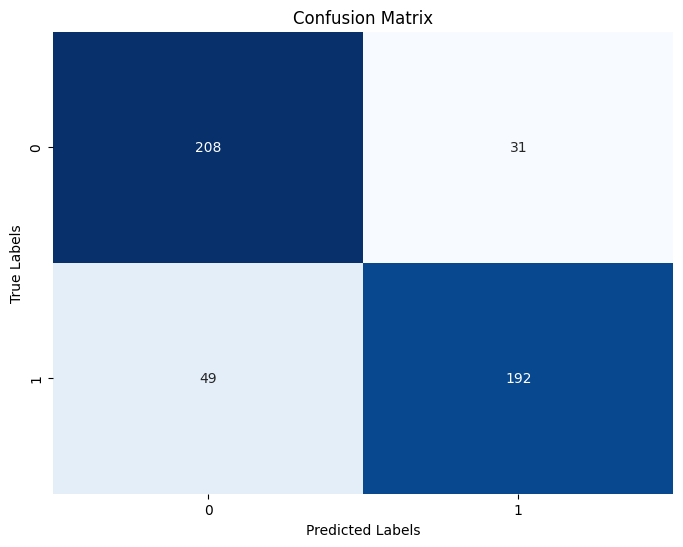

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(all_labels_ids, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()